In [20]:
import os
from zipfile import ZipFile
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import imageio
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [161]:
file_name = "breast-cancer.zip"
with ZipFile(file_name, 'r') as zip:  
    zip.extractall()
os.rename('Dataset_BUSI_with_GT', 'Dataset')

# Data Cleaning

During this process we explore images from Dataset folder, cleaning duplicates, and join masks that belongs from the same image

In [2]:
dirs = [os.path.join('Dataset', _) for _ in sorted(os.listdir('Dataset'))]

In [183]:
def get_duplicate_masks(files):
    duplicate_masks = []
    num = len(files)-1; i = 0
    while i < num:
        mask_name = files[i].rsplit('_',1)[0]
        duplicate = [files[i]]
        
        for j in range(i + 1, num):
            if mask_name in files[j]:
                duplicate.append(files[j])
        
        if len(duplicate) > 1:
            duplicate_masks.append(duplicate)
        i+=len(duplicate)
    return duplicate_masks

def combine_masks(path, duplicates):
    combined = None
    for dup in duplicates:
        image_path = os.path.join(path, dup)
        image = plt.imread(image_path)
        
        if len(image.shape) == 3:
            image = image[:,:,0]
            
        if combined is None:
            combined = image
        else:
            combined += image
        os.remove(image_path)
    save_path = os.path.join(path, duplicates[0])
    plt.imsave(save_path, combined, cmap = 'gray')

In [184]:
def data_cleaning(dirs):
    for dir_ in dirs:
        files = sorted(os.listdir(dir_))
        masks = [file for file in files if 'mask' in file]
        duplicate_masks = get_duplicate_masks(masks)
        
        for duplicate in duplicate_masks:
            combine_masks(dir_, duplicate)
data_cleaning(dirs)

# Data Tunneling

Preprocessing Data and Tunnel it into Tensorflow framework before being used to train the model

In [3]:
dirs = [os.path.join('Dataset', _) for _ in sorted(os.listdir('Dataset'))]

In [4]:
def load_image(image_path, name = None):
    img = load_img(image_path)
    img = img_to_array(img)
    img= tf.convert_to_tensor(img, dtype=tf.float32, name = name)
    img = tf.image.resize(img, (256, 256), method='nearest')
    return img

In [5]:
def create_dataset(dirs):
    images_dataset = []
    masks_dataset = []
    label_dataset = []
    for i in range(len(dirs)):
        files = sorted(os.listdir(dirs[i]))
        MASKS = [file for file in files if 'mask' in file]
        IMAGES = [file for file in files if not 'mask' in file]
        
        #Test if there's a mismatch with number of masks and images
        if len(MASKS) != len(IMAGES):
            print(f'Mismatch Masks and Images Count at {dirs[i]}:\n \
            Number of Masks: {len(MASKS)}, Number of Images: {len(IMAGES)}')
            return None
        
        ##Use load_image to convert images to tensor
        ##Assign tensor into a dictionaries and append it into the datase
        for id_ in range(len(MASKS)):
            img_path = os.path.join(dirs[i], IMAGES[id_])
            mask_path = os.path.join(dirs[i], MASKS[id_])
            
            image = load_image(img_path)
            mask = load_image(mask_path)
            label = tf.convert_to_tensor(i)
            
            ##Test the compatibility of shape in both images and masks
            if image.shape != mask.shape:
                print(f'Mismatch Masks and Images Shape at {img_path}:\n \
                Shape of Masks: {mask.shape}, Shape of Images: {images.shape}')
                return None
            
            mask = tf.image.rgb_to_grayscale(mask)
            images_dataset.append(image)
            masks_dataset.append(mask)
            label_dataset.append(label)
    
    #Convert dataset using tf.data.Dataset.from_tensor_slices and shuffle it
    dataset = tf.data.Dataset.from_tensor_slices((images_dataset, masks_dataset, label_dataset))
    dataset = dataset.shuffle(buffer_size = len(images_dataset))
    return dataset


In [6]:
dataset = create_dataset(dirs)

#Split dataset into train and validation set by 80-20
train_size = int(0.8 * len(dataset))
train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size)

In [7]:
##Preprocessing Layer: Normalize and Random Flip of Images and Masks
def random_flip(input_image, input_mask):
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    return input_image, input_mask


def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32)/255.0
    input_mask = tf.cast(input_mask, tf.float32)/255.0
    return input_image, input_mask

def preprocess_image(input_image, input_mask, input_label):
    input_image, input_mask = random_flip(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, (input_mask, input_label)



In [8]:
train_ds = train_ds.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.map(preprocess_image)

In [10]:
##Batch train and validation dataset
BATCH_SIZE = 32

##set train_dataset into batches and do a prefetch to optimize processing
train_dataset = train_ds.cache().batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
#set test_dataset into batches
val_dataset = val_ds.batch(BATCH_SIZE)

# Developing Model

## Encoder Block

In [30]:
class EncoderBlock(tf.keras.layers.Layer):
    def __init__(self, filters, rate, pooling = True, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.rate = rate
        self.pooling = pooling
        
        self.conv1 = tf.keras.layers.Conv2D(filters, kernel_size=3, strides=1, padding='same', 
                                            activation='relu', 
                                            kernel_initializer='he_normal')
        self.drop = tf.keras.layers.Dropout(rate)
        self.conv2 = tf.keras.layers.Conv2D(filters, kernel_size=3, strides=1, padding='same', 
                                            activation='relu',
                                            kernel_initializer='he_normal')
        self.maxpool = tf.keras.layers.MaxPool2D()
    
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.drop(x)
        x = self.conv2(x)
        if self.pooling:
            y = self.maxpool(x)
            return y,x
        else:
            return x
    
    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            'filters': self.filters,
            'rate': self.rate,
            'pooling': self.pooling
        }

## Decoder

In [31]:
class DecoderBlock(tf.keras.layers.Layer):
    def __init__(self, filters, rate, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.rate = rate
        
        self.upsample = tf.keras.layers.UpSampling2D()
        self.net = EncoderBlock(filters, rate, pooling = False)
    
    def call(self, inputs):
        inputs, skip_inputs = inputs
        x = self.upsample(inputs)
        c_ = tf.keras.layers.concatenate([x,skip_inputs])
        x = self.net(c_)
        return x
    
    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            'filters': self.filters,
            'rate': self.rate
        }

## Attention Gate

In [32]:
class AttentionGate(tf.keras.layers.Layer):
    def __init__(self, filters, bn, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.bn = bn
        self.normal = tf.keras.layers.Conv2D(filters, kernel_size = 3,
                                             padding = 'same',
                                             activation=tf.keras.layers.LeakyReLU(alpha=0.2),
                                             kernel_initializer = 'he_normal')
        self.down = tf.keras.layers.Conv2D(filters, kernel_size = 3,
                                           strides = 2, padding = 'same',
                                           activation=tf.keras.layers.LeakyReLU(alpha=0.2),
                                           kernel_initializer = 'he_normal')
        self.learn = tf.keras.layers.Conv2D(1, kernel_size = 1, padding = 'same',
                                            activation = 'sigmoid')
        self.resample = tf.keras.layers.UpSampling2D()
        self.BN = tf.keras.layers.BatchNormalization()
    
    def call(self, inputs):
        inputs, skip_inputs = inputs
        x = self.normal(inputs)
        skip = self.down(skip_inputs)
        x = self.learn(x)
        x = self.resample(x)
        f = tf.keras.layers.Multiply()([x, skip_inputs])
        if self.bn:
            return self.BN(f)
        else:
            return f
    
    def get_config(self):
        base_config = super().get_config()
        return {
            **base_config,
            'filters': self.filters,
            'bn': self.bn
        }

## Attention UNet

In [40]:
#Inputs
input_layer = tf.keras.Input(shape = (256,256,3))


# Encoder
p1, c1 = EncoderBlock(32,0.1, name="Encoder1")(input_layer)
p2, c2 = EncoderBlock(64,0.1, name="Encoder2")(p1)
p3, c3 = EncoderBlock(128,0.2, name="Encoder3")(p2)
p4, c4 = EncoderBlock(256,0.2, name="Encoder4")(p3)

# Encoding
encoding = EncoderBlock(512,0.3, pooling=False, name="Encoding")(p4)

# Attention + Decoder

a1 = AttentionGate(256, bn=True, name="Attention1")([encoding, c4])
d1 = DecoderBlock(256,0.2, name="Decoder1")([encoding, a1])

a2 = AttentionGate(128, bn=True, name="Attention2")([d1, c3])
d2 = DecoderBlock(128,0.2, name="Decoder2")([d1, a2])

a3 = AttentionGate(64, bn=True, name="Attention3")([d2, c2])
d3 = DecoderBlock(64,0.1, name="Decoder3")([d2, a3])


a4 = AttentionGate(32, bn=True, name="Attention4")([d3, c1])
d4 = DecoderBlock(32,0.1, name="Decoder4")([d3, a4])

#Classification Layer
x = tf.keras.layers.Dropout(.2)(encoding)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(64, activation = 'relu')(x)

# Output 
output_layer = tf.keras.layers.Conv2D(1, kernel_size=1, 
                                     activation='sigmoid', 
                                     padding='same',
                                     name = 'output_unet')(d4)
class_layer = tf.keras.layers.Dense(3, activation = 'softmax',
                                   name = 'output_class')(x)

model = tf.keras.Model(
    inputs = [input_layer],
    outputs = [output_layer, class_layer]
)


In [41]:
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1,2,3])
    union = tf.reduce_sum(y_true, axis=[1,2,3]) + tf.reduce_sum(y_pred, axis=[1,2,3])
    dice = tf.reduce_mean((2. * intersection + smooth) / (union + smooth), axis=0)
    return dice

def dice_loss(y_true, y_pred, smooth=1e-6):
    return 1 - dice_coefficient(y_true, y_pred, smooth)

def combined_loss(y_true, y_pred):
    ce_loss = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    return ce_loss + dice_loss(y_true, y_pred)

In [42]:
model.compile(
    loss={'output_unet': combined_loss, 'output_class': 'sparse_categorical_crossentropy'},
    optimizer=tf.keras.optimizers.Adam(),
    metrics={'output_unet': 'accuracy', 'output_class': 'accuracy'}
)

## Custom Callback

In [43]:
class ShowProgress(tf.keras.callbacks.Callback):
    def __init__(self, filename = 'progress.gif'):
        super().__init__()
        self.filename = filename
        self.images = []
        
    '''Callbacks to show the progress of how model predicts the validation dataset'''
    def on_epoch_end(self, epochs, logs = None):
        class_types = ['benign', 'malignant', 'normal']
        ##Display predictions for every 10 epochs
        if epochs % 10 == 0:
            for image, (mask, label) in val_dataset.take(1):
                
                ## Create figure and iterate through each subplot
                fig, axes = plt.subplots(1, 4, figsize=(8, 3))
                for i in range(4):
                    ax = axes[i]
                    
                    ##Predict mask and label with available model on the given images
                    img = tf.expand_dims(image[i], 0)
                    prediction = model.predict(img)
                    p_mask = prediction[0][0]
                    p_label = np.argmax(prediction[1][0])
                    
                    ##Show the predicted masks and label with respect to each images
                    ax.imshow(image[i])
                    ax.imshow(p_mask, cmap='magma', alpha = .4)
                    
                    ##Change label color with respect to ground truth
                    color = 'red'
                    if label[i] == p_label:
                        color = 'blue'
        
                    ax.set_title(class_types[p_label], color = color)
                    ax.axis('off')
                
                plt.tight_layout(pad =.1)
                plt.suptitle(f'Epoch {epochs}')
                ## Save the figure to a temporary file
                tmp_file = f"epoch_{epochs}_fig.png"
                plt.savefig(tmp_file)
                plt.close(fig)
                
                # Append the temporary file to the list of images
                self.images.append(imageio.imread(tmp_file))
                
                #Remove tmp file
                os.remove(tmp_file)
            
        # Save all images as a GIF at the end of training
        imageio.mimsave(self.filename, self.images, fps=1)
            
    def set_params(self, params):
        self.epochs = params['epochs']

reduceLR= tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=10, min_lr=1e-6)

checkPoint = tf.keras.callbacks.ModelCheckpoint("AttentionCustomUNet.h5", save_best_only=True)

In [44]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=150,
    callbacks = [ShowProgress(), reduceLR, checkPoint]
    )

Epoch 1/150
20/20 [==============================] - ETA: 0s - loss: 7.9706 - output_unet_loss: 3.0607 - output_class_loss: 4.9099 - output_unet_accuracy: 0.8953 - output_class_accuracy: 0.4728

/tmp/ipykernel_2711103/365377481.py:45: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  self.images.append(imageio.imread(tmp_file))


20/20 [==============================] - 14s 490ms/step - loss: 7.9706 - output_unet_loss: 3.0607 - output_class_loss: 4.9099 - output_unet_accuracy: 0.8953 - output_class_accuracy: 0.4728 - val_loss: 2.2984 - val_output_unet_loss: 1.2697 - val_output_class_loss: 1.0287 - val_output_unet_accuracy: 0.9242 - val_output_class_accuracy: 0.5641 - lr: 0.0010
Epoch 2/150
20/20 [==============================] - 6s 284ms/step - loss: 2.0642 - output_unet_loss: 1.0768 - output_class_loss: 0.9874 - output_unet_accuracy: 0.8919 - output_class_accuracy: 0.5625 - val_loss: 2.2442 - val_output_unet_loss: 1.2162 - val_output_class_loss: 1.0280 - val_output_unet_accuracy: 0.9209 - val_output_class_accuracy: 0.6090 - lr: 0.0010
Epoch 3/150
20/20 [==============================] - 6s 297ms/step - loss: 1.9672 - output_unet_loss: 0.9863 - output_class_loss: 0.9809 - output_unet_accuracy: 0.8912 - output_class_accuracy: 0.5625 - val_loss: 2.2286 - val_output_unet_loss: 1.1860 - val_output_class_loss: 1.04

# Visualization

In [45]:
def plot_metrics(metric_name, title, ylim=1):
    '''plots a given metric from the model history'''
    plt.figure(figsize = (5,2))
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)
    plt.legend()

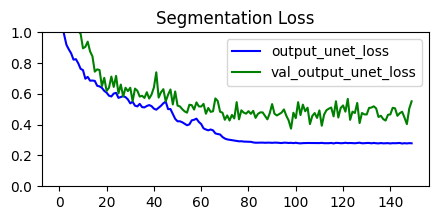

In [46]:
plot_metrics('output_unet_loss', 'Segmentation Loss')

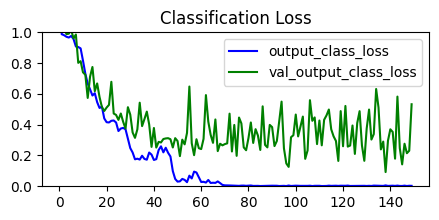

In [47]:
plot_metrics('output_class_loss', 'Classification Loss')

In [48]:
def gif_utils(filename = 'final_result.gif'):
    class_types = ['benign', 'malignant', 'normal']
    images = []
    for _ in range(15):
        for image, (mask, label) in val_dataset.take(1):
                
            ## Create figure and iterate through each subplot
            fig, axes = plt.subplots(2, 4, figsize=(10, 5))
            for i in range(4):
                ax = axes[0,i]
                ax_g = axes[1,i]
            
                ##Predict mask and label with available model on the given images
                img = tf.expand_dims(image[i], 0)
                prediction = model.predict(img)
                p_mask = prediction[0][0]
                p_label = np.argmax(prediction[1][0])
                    
                ##Show the predicted masks and label with respect to each images
                ax.imshow(image[i])
                ax.imshow(p_mask, cmap='magma', alpha = .4)
            
                ##Compare with ground truth masks
                ax_g.imshow(image[i])
                ax_g.imshow(mask[i], cmap = 'magma', alpha = .4)
            
                ##Change label color with respect to ground truth
                color = 'red'
                if label[i] == p_label:
                    color = 'blue'
        
                ax.set_title(class_types[p_label], color = color)
                ax.axis('off')
                ax_g.axis('off')
                
            plt.tight_layout(pad =.1)
            ## Save the figure to a temporary file
            tmp_file = f"iteration_{_}_fig.png"
            plt.savefig(tmp_file)
            plt.close(fig)
                
            # Append the temporary file to the list of images
            images.append(imageio.imread(tmp_file))
                
            #Remove tmp file
            os.remove(tmp_file)
            
    # Save all images as a GIF at the end of training
    imageio.mimsave(filename, images, fps=1)

In [49]:
gif_utils()

/tmp/ipykernel_2711103/4244938293.py:43: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(tmp_file))
